In [1]:
import pandas as pd
import numpy as np
import os
import pdb
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from matplotlib import cm
import matplotlib.pyplot as plt

In [2]:
import time
import matplotlib
import numpy as np
from numpy import pi as PI
from matplotlib import pyplot as plt

from paddle import fluid
from paddle.fluid.framework import ComplexVariable
from paddle.complex import matmul, transpose
from paddle_quantum.circuit import UAnsatz
from paddle_quantum.utils import pauli_str_to_matrix

图像数据集
----

In [3]:
#root = '/home/johnson-lin/Downloads'
#npz_file = np.load(os.path.join(root, 'organmnist_coronal.npz'))
npz_file = np.load('../datasets/pneumoniamnist.npz')
train_data = npz_file['train_images']
train_labels =  npz_file['train_labels']
val_data = npz_file['val_images']
val_labels =  npz_file['val_labels']
test_data = npz_file['test_images']
test_labels =  npz_file['test_labels']

In [4]:
def show_images(images, labels):
    _, figs = plt.subplots(1, len(images), figsize=(28, 28))
    for f, img, lbl in zip(figs, images, labels):
        f.imshow(img, cmap='gray')
        f.set_title(lbl)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()

/home/johnson/anaconda3/envs/paddle/lib/python3.6/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


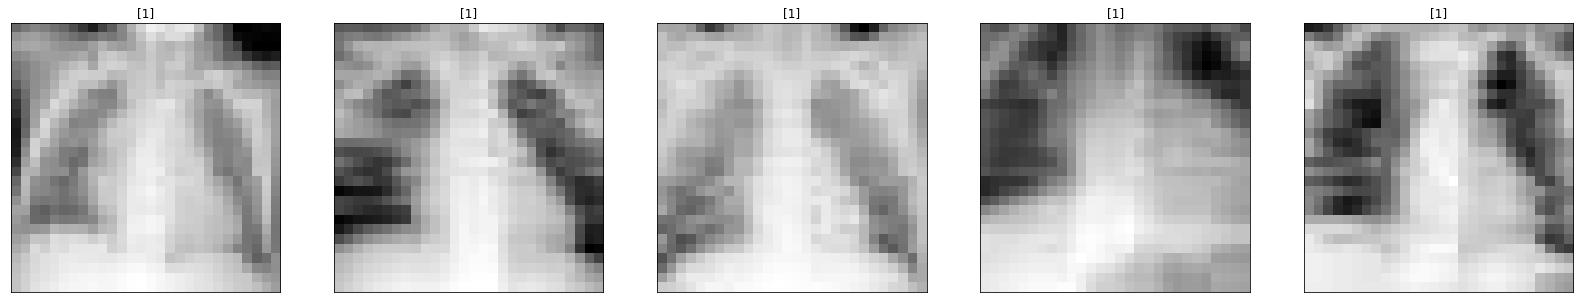

In [5]:
X, y = [], []
for i in range(5):
    X.append(train_data[i])
    y.append(train_labels[i])
show_images(X, y)

分子的数字信息
---

In [6]:
tsne=TSNE(min_grad_norm=1e-5,init='pca',method='exact',angle=0.45,early_exaggeration=5,n_iter=1000)
pca = PCA(n_components=2)

reduction_model = pca
all_code = np.concatenate([train_data, test_data], axis=0)

In [7]:
reduct_code=reduction_model.fit_transform(all_code.reshape(all_code.shape[0], -1))

In [8]:
Q_code = reduct_code[:train_data.shape[0]]
Q1_code = reduct_code[train_data.shape[0]:]

In [9]:
Q_code.shape

(4708, 2)

数据的可视化
----

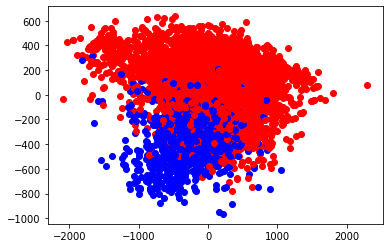

In [10]:
for i in range(len(train_data)):
    if train_labels[i]== 1:
        plt.scatter(Q_code.T[0][i],Q_code.T[1][i],color='r')
    else:
        plt.scatter(Q_code.T[0][i],Q_code.T[1][i],color='b')

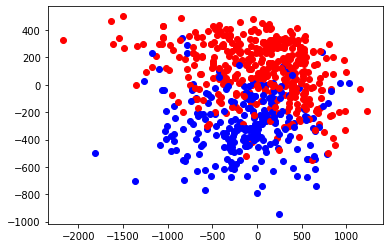

In [11]:
tmp = Q1_code.T
for i in range(len(test_labels)):
    if tmp[1][i] > 1000:
        tmp[1][i]=-500.0
    if test_labels[i]== 1:
        plt.scatter(tmp[0][i],tmp[1][i],color='r')
    else:
        plt.scatter(tmp[0][i],tmp[1][i],color='b')

In [12]:
sum=0
print(len(test_labels))
for i in range(len(test_labels)):
    if test_labels[i]== 1:
        sum=sum+1
print(sum)

624
390


In [13]:
sum=0
print(len(train_labels))
for i in range(len(train_labels)):
    if train_labels[i]== 1:
        sum=sum+1
print(sum)

4708
3494


In [14]:
sum=0
print(len(val_labels))
for i in range(len(val_labels)):
    if val_labels[i]== 1:
        sum=sum+1
print(sum)

524
389


In [15]:
QQQ_code=preprocessing.normalize(Q_code, norm="l1", axis=1)

In [16]:
QQQ1_code=preprocessing.normalize(Q1_code, norm="l1", axis=1)

In [17]:
QQQ_code.shape

(4708, 2)

量子分类器和训练
----


In [18]:
def myRy(theta):
    """
    :param theta: parameter
    :return: Y rotation matrix
    """
    return np.array([[np.cos(theta / 2), -np.sin(theta / 2)],
                     [np.sin(theta / 2), np.cos(theta / 2)]])

def myRz(theta):
    """
    :param theta: parameter
    :return: Z rotation matrix
    """
    return np.array([[np.cos(theta / 2) - np.sin(theta / 2) * 1j, 0],
                     [0, np.cos(theta / 2) + np.sin(theta / 2) * 1j]])

# 经典 -> 量子数据编码器
def datapoints_transform_to_state(data, n_qubits):
    """
    :param data: shape [-1, 2]
    :param n_qubits: the number of qubits to which the data transformed
    :return: shape [-1, 1, 2 ^ n_qubits]
    """
    dim1, dim2 = data.shape
    res = []
    for sam in range(dim1):
        res_state = 1.
        zero_state = np.array([[1, 0]])
        for i in range(n_qubits):
            if i % 2 == 0:
                state_tmp=np.dot(zero_state, myRy(np.arcsin(data[sam][0])).T)
                state_tmp=np.dot(state_tmp, myRz(np.arccos(data[sam][0] ** 2)).T)
                res_state=np.kron(res_state, state_tmp)
            elif i % 2 == 1:
                state_tmp=np.dot(zero_state, myRy(np.arcsin(data[sam][1])).T)
                state_tmp=np.dot(state_tmp, myRz(np.arccos(data[sam][1] ** 2)).T)
                res_state=np.kron(res_state, state_tmp)
        res.append(res_state)

    res = np.array(res)
    return res.astype("complex128")

#print("作为测试我们输入以上的经典信息:")
#print("(x_0, x_1) = (1, 0)")
#print("编码后输出的2比特量子态为:")
#print(datapoints_transform_to_state(np.array(qqq), n_qubits=2))

In [19]:
def U_theta(theta, n, depth):  
    """
    :param theta: dim: [n, depth + 3]
    :param n: number of qubits
    :param depth: circuit depth
    :return: U_theta
    """
    # 初始化网络
    cir = UAnsatz(n)
    
    # 先搭建广义的旋转层
    for i in range(n):
        cir.rz(theta[i][0], i)
        cir.ry(theta[i][1], i)
        cir.rz(theta[i][2], i)

    # 默认深度为 depth = 1
    # 搭建纠缠层和 Ry旋转层
    for d in range(3, depth + 3):
        for i in range(n-1):
            cir.cnot([i, i + 1])
        cir.cnot([n-1, 0])
        for i in range(n):
            cir.ry(theta[i][d], i)

    return cir.U

In [20]:
def Observable(n):
    """
    :param n: number of qubits
    :return: local observable: Z \otimes I \otimes ...\otimes I
    """
    Ob = pauli_str_to_matrix([[1.0, 'z0']], n)
    return Ob

In [21]:
class Net(fluid.dygraph.Layer):
    """
    Construct the model net
    """
    def __init__(self,
                 n,      # number of qubits
                 depth,  # circuit depth
                 seed_paras=1,
                 dtype='float64'):
        super(Net, self).__init__()

        self.n = n
        self.depth = depth
        
        # 初始化参数列表 theta，并用 [0, 2*pi] 的均匀分布来填充初始值
        self.theta = self.create_parameter(
            shape=[n, depth + 3],
            attr=fluid.initializer.Uniform(
                low=0.0, high=2*PI, seed=seed_paras),
            dtype=dtype,
            is_bias=False)
        
        # 初始化偏置 (bias)
        self.bias = self.create_parameter(
            shape=[1],
            attr=fluid.initializer.NormalInitializer(
                scale=0.01, seed=seed_paras + 10),
            dtype=dtype,
            is_bias=False)

    # 定义向前传播机制、计算损失函数 和交叉验证正确率
    def forward(self, state_in, label):
        """
        Args:
            state_in: The input quantum state, shape [-1, 1, 2^n]
            label: label for the input state, shape [-1, 1]
        Returns:
            The loss:
                L = ((<Z> + 1)/2 + bias - label)^2
        """
        
        # 我们需要将 Numpy array 转换成 Paddle 动态图模式中支持的 variable
        Ob = fluid.dygraph.to_variable(Observable(self.n))
        #pdb.set_trace()
        label_pp = fluid.dygraph.to_variable(label)
        # 按照随机初始化的参数 theta 
        Utheta = U_theta(self.theta, n=self.n, depth=self.depth)
        
        # 因为 Utheta是学习得到的，我们这里用行向量运算来提速而不会影响训练效果
        state_out = matmul(state_in, Utheta)  # 维度 [-1, 1, 2 ** n]
        
        # 测量得到泡利 Z 算符的期望值 <Z>
        E_Z = matmul(matmul(state_out, Ob),
                     transpose(ComplexVariable(state_out.real, -state_out.imag),
                               perm=[0, 2, 1]))
        
        # 映射 <Z> 处理成标签的估计值 
        state_predict = E_Z.real[:, 0] * 0.5 + 0.5 + self.bias
        loss = fluid.layers.reduce_mean((state_predict - label_pp) ** 2)
        #pdb.set_trace()
        # 计算交叉验证正确率
        #is_correct = fluid.layers.where(
            #fluid.layers.abs(state_predict - label_pp) < 0.5).shape[0]
        #acc = is_correct / label.shape[0]

        return loss, state_predict.numpy()

In [22]:
step=1
BATCH = 1
EPOCH = 10
total_loss = 0.0

with fluid.dygraph.guard():
    net = Net(n=4, depth=3, seed_paras=19)
    opt = fluid.optimizer.AdamOptimizer(learning_rate=0.01, parameter_list=net.parameters())
    
    tr_ls = []
    for epoch in range(EPOCH):
        epoch_ls = 0
        data_len = 0
        for i in range(len(train_data) // BATCH):
            step=step+1
            #inputx=[]
            #pdb.set_trace()
            #inputx.append(QQQ_code[i * BATCH:(i + 1) * BATCH])
            inputx = QQQ_code[i * BATCH:(i + 1) * BATCH]
            inputx=np.asarray(inputx)

            trainx=np.array(inputx).astype('float64')
            input_data=fluid.dygraph.to_variable(datapoints_transform_to_state(trainx,n_qubits=4))
            #print(input_data)
            inputy=(train_labels[i * BATCH:(i + 1) * BATCH].reshape(-1))  
            #pdb.set_trace()
            trainy=np.asarray(inputy).astype('float64')
            #print('label:--',trainy)
            loss, state=net(state_in=input_data,label=trainy)
            
            #pdb.set_trace()
            #is_correct = fluid.layers.where(
            #fluid.layers.abs(state - trainy) < 0.5)#.shape[0]
            #print('step:',i,'; loss:',loss)
            
            total_loss += loss.numpy()[0]

            loss.backward()
            opt.minimize(loss)
            net.clear_gradients()
            epoch_ls += loss.numpy().sum()
            data_len += BATCH
        
      
            if (i) % 1000 ==0:
                print('------------------------------TEST---------------------------------')
                summary_test_correct=0
                for j in range(len(test_data) // BATCH):
                    #lll=test_data[j]
                    label_test=(test_labels[j * BATCH:(j + 1) * BATCH].reshape(-1))
                    label_test = np.asarray(label_test).astype('float64')
                    #input_test=[]
                    #input_test.append(QQQ1_code[j])
                    input_test = QQQ1_code[j * BATCH:(j + 1) * BATCH]
                    input_test=np.asarray(input_test)
                    input_test=np.array(input_test).astype('float64')
                    #pdb.set_trace()
                    input_test=fluid.dygraph.to_variable(datapoints_transform_to_state(input_test,n_qubits=4))
                    loss, state=net(state_in=input_test,label=label_test)
                    is_correct=(np.abs(state.reshape(-1)-label_test)<0.5)+0
                    #with open('state.txt', 'a') as f:
                        #f.write(str(state)+'\n')
                        #f.write(str(label_test)+'\n')
                        #f.write(str(is_correct)+'\n')
                        #f.write('\n')
                    is_correct=is_correct.sum()
                    #pdb.set_trace()
                    summary_test_correct=summary_test_correct+is_correct
                print( epoch ,summary_test_correct, len(test_labels))
                #print( epoch ,acc, test_acc)
        tr_ls.append(epoch_ls / data_len)
    print(tr_ls)
        
            
                

------------------------------TEST---------------------------------
0 149 624
------------------------------TEST---------------------------------
0 500 624
------------------------------TEST---------------------------------
0 513 624
------------------------------TEST---------------------------------
0 487 624
------------------------------TEST---------------------------------
0 492 624
------------------------------TEST---------------------------------
1 490 624
------------------------------TEST---------------------------------
1 518 624
------------------------------TEST---------------------------------
1 514 624
------------------------------TEST---------------------------------
1 487 624
------------------------------TEST---------------------------------
1 491 624
------------------------------TEST---------------------------------
2 491 624
------------------------------TEST---------------------------------
2 518 624
------------------------------TEST------------------------------